In [2]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix
from keras import Sequential

In [3]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/patrycja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/patrycja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [109]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [110]:
extra_train = JigsawData(MAX_WORD_NUM)
extra_train.load_data("data/train.csv")
extra_df_preprocessed = extra_train.preprocess()

In [111]:
print(train_df_preprocessed)
print(train_data_semeval.get_classes_amount(train_df_preprocessed))
##add data 
additional_data = extra_train.get_missing_class_elements(extra_df_preprocessed, 100, 0.0)
print(additional_data)
frames = [train_df_preprocessed, additional_data]
train_df_preprocessed = pd.concat(frames)
# train_df_preprocessed
print(train_data_semeval.get_classes_amount(train_df_preprocessed))

                                                 spans  \
0             [15, 16, 17, 18, 19, 27, 28, 29, 30, 31]   
1                             [29, 30, 31, 32, 33, 34]   
2                       [166, 167, 168, 169, 170, 171]   
3                             [87, 88, 89, 90, 91, 92]   
4                                                   []   
..                                                 ...   
685                     [129, 130, 131, 132, 133, 134]   
686                     [126, 127, 128, 129, 130, 131]   
687                           [24, 25, 26, 27, 28, 29]   
688  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
689                     [136, 137, 138, 139, 140, 141]   

                                                  text  toxicity  \
0    because hes a moron and a bigot. its not any m...         1   
1    how about we stop protecting idiots and let na...         1   
2    if people  were  smart, they would  boycott th...         1   
3    trump claimed that russia 

In [112]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,toxicity_sentence
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1.0,"[moron, bigot]",Because he's a moron and a bigot. It's not any...,"[because hes a moron and a bigot., its not any...","[1.0, 0.0]"
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1.0,[idiots],How about we stop protecting idiots and let na...,[how about we stop protecting idiots and let n...,"[1.0, 0.0]"
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1.0,[idiots],"If people were smart, they would Boycott th...","[if people were smart, they would boycott t...",[1.0]
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1.0,[stupid],Trump Claimed that Russia will never invade th...,[trump claimed that russia will never invade t...,[1.0]
4,[],as long as your willing to pay a lot more for ...,0.0,[],As long as your willing to pay a lot more for ...,[as long as your willing to pay a lot more for...,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
31562,NaN,i noticed vandalisms on nov. 20 that made me f...,0.0,NaN,NaN,[i noticed vandalisms on nov. 20 that made me ...,[0.0]
131444,NaN,i personally think it works better in the intr...,0.0,NaN,NaN,[i personally think it works better in the int...,[0.0]
127479,NaN,"well, in a perfect world it would depend on th...",0.0,NaN,NaN,"[well, in a perfect world it would depend on t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38305,NaN,{{unblock| sir please unblock me. hearafter il...,0.0,NaN,NaN,"[{{unblock| sir please unblock me., hearafter ...","[0.0, 0.0, 0.0, 0.0]"


In [113]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###

In [114]:
train_df

,sentence,toxicity_sentence
0,because hes a moron and a bigot.,1.0
1,its not any more complicated than that.,0.0
2,how about we stop protecting idiots and let na...,1.0
3,we can always submit their names for the darwi...,0.0
4,"if people were smart, they would boycott th...",1.0
...,...,...
2409,it was deleted under our speedy-deletion crite...,0.0
2410,if you think this has been in error you can ap...,0.0
2411,"alternatively, you can request a review at del...",0.0
2412,please do not simply recreate the article if y...,0.0


In [115]:
train_df[train_df.toxicity_sentence == 0.0].shape

(1631, 2)

In [116]:
len(train_df)

2414

In [117]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [118]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [119]:
#filter stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
for i, w in enumerate(sentences):
    sentences[i] = [w for w in sentences[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrycja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
sentences = [x for x in sentences if x!=[]]

In [121]:
sentences 

[['hes', 'moron', 'bigot'],
 ['complicated'],
 ['stop',
  'protecting',
  'idiots',
  'let',
  'nature',
  'add',
  'bleach',
  'gene',
  'pool'],
 ['always', 'submit', 'names', 'darwin', 'awards'],
 ['people',
  'smart',
  'would',
  'boycott',
  'inept',
  'airline',
  'smart',
  'rogue',
  'businesses',
  'like',
  'one',
  'still',
  'thrive',
  'taking',
  'idiots',
  'ride'],
 ['trump',
  'claimed',
  'russia',
  'never',
  'invade',
  'ukraine',
  'russia',
  'already',
  'stupid',
  'people'],
 ['long', 'willing', 'pay', 'lot', 'products', 'buy', 'fine'],
 ['better', 'going', 'costco', 'walmart', 'buy', 'stuff', 'cheaper'],
 ['get', 'call', 'hypocritical', 'wanker'],
 ['idiot',
  'would',
  'use',
  'believe',
  'anything',
  'republican',
  'propaganda',
  'machine',
  'publishes'],
 ['thanks', 'lot', 'douchebag'],
 ['youre',
  'reason',
  'portland',
  'buttfuckers',
  'getting',
  'pushed',
  'moving',
  'south',
  'wilsonville',
  'area',
  'beyond'],
 ['stupid',
  'fucking

In [122]:
len(sentences)

2363

In [123]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [124]:
word_index

{'people': 1,
 'stupid': 2,
 'trump': 3,
 'like': 4,
 'dont': 5,
 'would': 6,
 'one': 7,
 'get': 8,
 'idiot': 9,
 'article': 10,
 'know': 11,
 'good': 12,
 'think': 13,
 'time': 14,
 'see': 15,
 'go': 16,
 'never': 17,
 'us': 18,
 'make': 19,
 'even': 20,
 'ignorant': 21,
 'want': 22,
 'idiots': 23,
 'right': 24,
 'also': 25,
 'white': 26,
 'cant': 27,
 'way': 28,
 'money': 29,
 'could': 30,
 'youre': 31,
 'said': 32,
 'another': 33,
 'please': 34,
 'much': 35,
 'back': 36,
 'page': 37,
 'president': 38,
 'believe': 39,
 'thats': 40,
 'keep': 41,
 'stupidity': 42,
 'really': 43,
 'black': 44,
 'talk': 45,
 'world': 46,
 'im': 47,
 'hes': 48,
 'every': 49,
 'always': 50,
 'still': 51,
 'made': 52,
 'years': 53,
 'need': 54,
 'say': 55,
 'pathetic': 56,
 'country': 57,
 'wikipedia': 58,
 'stop': 59,
 'let': 60,
 'use': 61,
 'many': 62,
 'something': 63,
 'government': 64,
 'long': 65,
 'anything': 66,
 'help': 67,
 'last': 68,
 'away': 69,
 'life': 70,
 'state': 71,
 'man': 72,
 'someone

In [125]:
import gensim

In [126]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [127]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [128]:
word_index.items()

dict_items([('people', 1), ('stupid', 2), ('trump', 3), ('like', 4), ('dont', 5), ('would', 6), ('one', 7), ('get', 8), ('idiot', 9), ('article', 10), ('know', 11), ('good', 12), ('think', 13), ('time', 14), ('see', 15), ('go', 16), ('never', 17), ('us', 18), ('make', 19), ('even', 20), ('ignorant', 21), ('want', 22), ('idiots', 23), ('right', 24), ('also', 25), ('white', 26), ('cant', 27), ('way', 28), ('money', 29), ('could', 30), ('youre', 31), ('said', 32), ('another', 33), ('please', 34), ('much', 35), ('back', 36), ('page', 37), ('president', 38), ('believe', 39), ('thats', 40), ('keep', 41), ('stupidity', 42), ('really', 43), ('black', 44), ('talk', 45), ('world', 46), ('im', 47), ('hes', 48), ('every', 49), ('always', 50), ('still', 51), ('made', 52), ('years', 53), ('need', 54), ('say', 55), ('pathetic', 56), ('country', 57), ('wikipedia', 58), ('stop', 59), ('let', 60), ('use', 61), ('many', 62), ('something', 63), ('government', 64), ('long', 65), ('anything', 66), ('help', 

In [158]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=0
        absent_words+=1

In [159]:
len(word_index)

5420

In [160]:
absent_words

478

In [161]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [162]:
data_index.shape

(2363, 40)

In [163]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  48   95  976    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2263    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  59  977   23   60  978  205 2264 2265 1380    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  50 2266  722  979 1381    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  723    6 1382  572 2267  723 2268 1383    4    7   51 2269  230
    23 1384    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [164]:
y_train.shape

(1891, 1)

In [165]:
y_val.shape

(472, 1)

In [166]:
y_softmax_train = np.zeros((y_train.shape[0], 2))
y_softmax_val = np.zeros((y_val.shape[0], 2))

In [167]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [168]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

## Build model

In [191]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(2, kernel_regularizer=l2_reg, name='dense'),name='time_distributed'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1626300   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten_4 (Flatten)          (None, 80)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                

In [192]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1626300   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 100)           140400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 2)             202       
_________________________________________________________________
flatten_4 (Flatten)          (None, 80)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_final (Dense)          (None, 2)                

Epoch 1/25
2/2 [==============================] - 1s 739ms/step - loss: 0.6919 - acc: 0.5066 - val_loss: 0.6544 - val_acc: 0.6695
Epoch 2/25
2/2 [==============================] - 1s 443ms/step - loss: 0.6479 - acc: 0.6663 - val_loss: 0.6339 - val_acc: 0.6695
Epoch 3/25
2/2 [==============================] - 1s 360ms/step - loss: 0.6329 - acc: 0.6684 - val_loss: 0.6369 - val_acc: 0.6695
Epoch 4/25
2/2 [==============================] - 1s 365ms/step - loss: 0.6257 - acc: 0.6684 - val_loss: 0.6392 - val_acc: 0.6695
Epoch 5/25
2/2 [==============================] - 1s 360ms/step - loss: 0.6224 - acc: 0.6684 - val_loss: 0.6340 - val_acc: 0.6695
Epoch 6/25
2/2 [==============================] - 1s 410ms/step - loss: 0.6132 - acc: 0.6711 - val_loss: 0.6309 - val_acc: 0.6695
Epoch 7/25
2/2 [==============================] - 1s 358ms/step - loss: 0.6044 - acc: 0.6721 - val_loss: 0.6310 - val_acc: 0.6695
Epoch 8/25
2/2 [==============================] - 1s 366ms/step - loss: 0.5978 - acc: 0.67

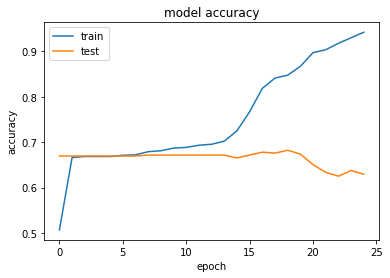

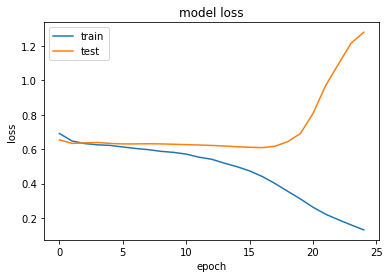

In [193]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=25, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm_w2v.h5')

### Explanation using LIME

For one example

In [173]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [174]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = y_val
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       316
         1.0       0.36      0.34      0.35       156

    accuracy                           0.58       472
   macro avg       0.52      0.52      0.52       472
weighted avg       0.58      0.58      0.58       472



In [175]:
from lime.lime_text import LimeTextExplainer

In [176]:
explainer = LimeTextExplainer(class_names=["NoToxic","Toxic"])

In [177]:
def new_predict_working(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return model.predict(data_temp)

In [194]:
def vectorize(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return data_temp

In [281]:
string = ' '.join([str(elem) for elem in sentences[2]]) 

For all samples

In [218]:
class Transform():
    def __init__(self):
        print("")
    
    def fit(self, X, y = None):
        print("")
        return self
    
    def transform(self, X, y =None):
        X_ = vectorize(X)
        return X_
    

In [219]:
t = Transform()

In [220]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(Transform(),model)

In [221]:
exp = explainer.explain_instance(string,c.predict_proba, num_features=6, top_labels = 2)

In [282]:
def getPredictedWordsFromSentence(sentence, threshold):
    print(sentence)
    y_pred = new_predict_working([sentence])
    if np.argmax(y_pred) == 1 :
        predicted_words = []
        exp = explainer.explain_instance(sentence,c.predict_proba, num_features=6, top_labels = 2)
        expWords = exp.as_list()
        maxScore = max(expWords, key = lambda i : i[1])[0]
        expWords = filter(lambda t: t[1] > threshold, expWords )
        wordsList = [i[0] for i in expWords]
        wordsList.append(maxScore) if maxScore not in wordsList else wordsList
        return wordsList
    else : return []

In [283]:
getPredictedWordsFromSentence(string, 0.25)

stop protecting idiots let nature add bleach gene pool


['protecting']